In [1]:
import datasets
from transformers import (
    VideoMAEImageProcessor,
    VideoMAEForVideoClassification,
    VideoMAEConfig,
    VideoMAEModel
)

from transformers import (
    VideoMAEImageProcessor,
    VideoMAEForVideoClassification,
    VideoMAEPreTrainedModel,
)
from transformers.modeling_outputs import ImageClassifierOutput
from pathlib import Path
import os
import torch
from torch import nn
import random
from typing import *
os.environ['WANDB_DISABLED']='true'

In [2]:
import imageio
import numpy as np
from IPython.display import Image

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)


In [3]:
class VideoMAEForMultilabelVideoClassification(VideoMAEPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.num_labels = config.num_labels
        self.videomae = VideoMAEModel(config)

        self.fc_norm = (
            nn.LayerNorm(config.hidden_size) if config.use_mean_pooling else None
        )
        self.classifier = (
            nn.Linear(config.hidden_size, config.num_labels)
            if config.num_labels > 0
            else nn.Identity()
        )
        # self.sigmoid = torch.nn.Sigmoid()
        # self.criterion = nn.BCELoss(reduction='none')
        self.criterion = nn.BCEWithLogitsLoss()
        self.post_init()


    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, ImageClassifierOutput]:

        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )
        outputs = self.videomae(
            pixel_values,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        if self.fc_norm is not None:
            sequence_output = self.fc_norm(sequence_output.mean(1))
        else:
            sequence_output = sequence_output[:, 0]

        logits = self.classifier(sequence_output)
        # logits = self.sigmoid(logits)

        loss = None
        if labels is not None:
            # logits = logits.reshape(-1, 1)
            # labels = labels.reshape(-1, 1)
            loss = self.criterion(logits, labels)#.reshape(-1)
            
            # possitive_loss = loss[labels.reshape(-1).long()==1].mean()
            # negative_loss = loss[labels.reshape(-1).long()!=1].mean()

            # loss = possitive_loss* 10 + negative_loss * 1
            # print('Positive loss: ',possitive_loss.item())
            # print('Negative loss: ',negative_loss.item())


        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return ImageClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [4]:
model_ckpt = "MCG-NJU/videomae-base"
batch_size = 3
target_path = "charades_HF"

In [5]:
datasets.config.DOWNLOADED_DATASETS_PATH = Path(target_path)
dataset = datasets.load_dataset("HuggingFaceM4/charades")

label2id = {label: i for i, label in enumerate(list(range(157)))}
id2label = {i: label for label, i in label2id.items()}

No config specified, defaulting to: charades/default
Found cached dataset charades (/home/jahid/.cache/huggingface/datasets/HuggingFaceM4___charades/default/0.0.0/c37f23dc5fc4916d250afb58fe981c5a68cfe30d9f78bc6d23a74ffa157618f7)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
config = VideoMAEConfig(
    problem_type="multi_label_classification",
    num_labels=len(label2id)
)
# config.problem_type = "multi_label_classification"
# config.num_labels = len(label2id)

image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForMultilabelVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  
)

Some weights of VideoMAEForMultilabelVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def get_path_and_label(dataset, video_root, split='train'):
    paths = [
        os.path.join(video_root, video_info['video_id']+'.mp4')
        for video_info in dataset[split]
    ]
    labels = [video_info['labels'] for video_info in dataset[split]]

    return paths, labels

train_path, train_labels = get_path_and_label(dataset, 'charades_HF/extracted/b1114f723459b513122220bfcf30b1b7423f65be17a11b936a8d29dbf1d83eba/Charades_v1')
test_path, test_labels = get_path_and_label(dataset, 'charades_HF/extracted/b1114f723459b513122220bfcf30b1b7423f65be17a11b936a8d29dbf1d83eba/Charades_v1', split='test')



zipped_train = list(zip(train_path, train_labels))
random.seed(37)
random.shuffle(zipped_train)


split_point = int(len(zipped_train)*.9)
zipped_train, zipped_eval = zipped_train[:split_point], zipped_train[split_point: ]
train_path, train_labels = zip(*zipped_train)
eval_path, eval_labels = zip(*zipped_eval)


len(train_path), len(train_labels), len(eval_path), len(eval_labels), len(test_path), len(test_labels)

(7186, 7186, 799, 799, 1863, 1863)

In [8]:
def collate_fn(examples):
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.stack([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [9]:
from dataset_config import DefaultConfig
from video_dataset.charades import VideoClsDataset

dataset_cfg = DefaultConfig()
dataset_cfg.num_sample = 1
dataset_cfg.height = 224

train_dataset = VideoClsDataset(
    data_path='',
    dataset_samples=train_path,
    label_array=train_labels,
    n_class=157,
    label2id=label2id,
    id2label=id2label,
    mode="validation",
    clip_len=16,
    frame_sample_rate=1,
    crop_size=224,
    short_side_size=224,
    new_height=224,
    new_width=224,
    keep_aspect_ratio=True,
    num_segment=1,
    num_crop=1,
    test_num_segment=10,
    test_num_crop=3,
    args=dataset_cfg,
)

eval_dataset = VideoClsDataset(
    data_path='',
    dataset_samples=eval_path[:-1],
    label_array=eval_labels[:-1],
    n_class=157,
    label2id=label2id,
    id2label=id2label,
    mode="validation",
    clip_len=16,
    frame_sample_rate=1,
    crop_size=224,
    short_side_size=224,
    # new_height=224,
    # new_width=224,
    keep_aspect_ratio=True,
    num_segment=1,
    num_crop=1,
    test_num_segment=10,
    test_num_crop=3,
    args=dataset_cfg,
)

from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    prefetch_factor=2,
    batch_size=batch_size
)

eval_loader = DataLoader(
    eval_dataset,
    prefetch_factor=2,
    batch_size=batch_size
)

In [10]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = "artifact_charades_original" #f"artifact_{model_name}_original"
num_epochs = 1

# args = TrainingArguments(
#     new_model_name,
#     remove_unused_columns=False,
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=5e-5,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     warmup_ratio=0.1,
#     logging_steps=10,
#     load_best_model_at_end=True,
#     # metric_for_best_model="accuracy",
#     # push_to_hub=True,
#     max_steps=(len(train_dataset)// batch_size) * num_epochs,
# )


args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="steps",
    eval_steps=1000,
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    half_precision_backend=True,
    logging_steps=10,
    load_best_model_at_end=True,
    save_strategy='steps',
    save_steps=1000,
    save_total_limit=3,
    max_steps=(len(train_dataset)// batch_size) * num_epochs,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [11]:
import evaluate
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    # predictions = np.argmax(eval_pred.predictions, axis=1)

    import numpy as np

    predictions = np.round(eval_pred.predictions).reshape(-1, 1)
    references = eval_pred.label_ids.reshape(-1, 1)
    m = metric.compute(predictions=predictions, references=references)
    print(m)
    return m


def compute_mAP(eval_pred):
    predictions = eval_pred.predictions
    references = eval_pred.label_ids

    # Apply sigmoid activation to predictions
    sigmoid_predictions = 1 / (1 + np.exp(-predictions))

    # Reshape predictions and references if necessary
    sigmoid_predictions = np.round(sigmoid_predictions)
    
    precision = 0

    for reference, prediction in zip(references, sigmoid_predictions):
        reference, prediction = reference.astype(np.int32), prediction.astype(np.int32)
        relevant_pred = prediction[reference!=0]
        precision +=  np.sum(relevant_pred)/len(relevant_pred)

    # recall
    return {'mAP': 100*round(precision/len(references), 4)}

In [14]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    # tokenizer=image_processor,
    compute_metrics=compute_mAP,
    data_collator=collate_fn,
)

In [16]:
train_results = trainer.train()

  0%|          | 0/2395 [00:00<?, ?it/s]

{'loss': 0.6953, 'learning_rate': 2.0833333333333334e-06, 'epoch': 0.0}
{'loss': 0.6935, 'learning_rate': 4.166666666666667e-06, 'epoch': 0.01}
{'loss': 0.685, 'learning_rate': 6.25e-06, 'epoch': 0.01}
{'loss': 0.6635, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.02}
{'loss': 0.6383, 'learning_rate': 1.0416666666666668e-05, 'epoch': 0.02}
{'loss': 0.596, 'learning_rate': 1.25e-05, 'epoch': 0.03}
{'loss': 0.5411, 'learning_rate': 1.4583333333333335e-05, 'epoch': 0.03}
{'loss': 0.4815, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.03}
{'loss': 0.4374, 'learning_rate': 1.8750000000000002e-05, 'epoch': 0.04}
{'loss': 0.4044, 'learning_rate': 2.0833333333333336e-05, 'epoch': 0.04}
{'loss': 0.3772, 'learning_rate': 2.2916666666666667e-05, 'epoch': 0.05}
{'loss': 0.3592, 'learning_rate': 2.5e-05, 'epoch': 0.05}
{'loss': 0.3418, 'learning_rate': 2.7083333333333332e-05, 'epoch': 0.05}
{'loss': 0.3221, 'learning_rate': 2.916666666666667e-05, 'epoch': 0.06}
{'loss': 0.3047, 'learning_

  0%|          | 0/266 [00:00<?, ?it/s]

/tmp/ipykernel_156531/4156136040.py:32: RuntimeWarning: invalid value encountered in long_scalars
  precision +=  np.sum(relevant_pred)/len(relevant_pred)


{'eval_loss': 0.15044763684272766, 'eval_mAP': nan, 'eval_runtime': 894.9738, 'eval_samples_per_second': 0.892, 'eval_steps_per_second': 0.297, 'epoch': 0.42}
{'loss': 0.1707, 'learning_rate': 3.213457076566126e-05, 'epoch': 0.42}
{'loss': 0.1525, 'learning_rate': 3.1902552204176334e-05, 'epoch': 0.43}
{'loss': 0.1529, 'learning_rate': 3.167053364269142e-05, 'epoch': 0.43}
{'loss': 0.1637, 'learning_rate': 3.14385150812065e-05, 'epoch': 0.43}
{'loss': 0.144, 'learning_rate': 3.120649651972158e-05, 'epoch': 0.44}
{'loss': 0.1562, 'learning_rate': 3.097447795823666e-05, 'epoch': 0.44}
{'loss': 0.1596, 'learning_rate': 3.0742459396751744e-05, 'epoch': 0.45}
{'loss': 0.1398, 'learning_rate': 3.0510440835266824e-05, 'epoch': 0.45}
{'loss': 0.1488, 'learning_rate': 3.0278422273781904e-05, 'epoch': 0.45}
{'loss': 0.1542, 'learning_rate': 3.0046403712296984e-05, 'epoch': 0.46}
{'loss': 0.1552, 'learning_rate': 2.9814385150812068e-05, 'epoch': 0.46}
{'loss': 0.167, 'learning_rate': 2.9582366589

  0%|          | 0/266 [00:00<?, ?it/s]

/tmp/ipykernel_156531/4156136040.py:32: RuntimeWarning: invalid value encountered in long_scalars
  precision +=  np.sum(relevant_pred)/len(relevant_pred)


{'eval_loss': 0.14874112606048584, 'eval_mAP': nan, 'eval_runtime': 895.2767, 'eval_samples_per_second': 0.891, 'eval_steps_per_second': 0.297, 'epoch': 0.83}
{'loss': 0.1449, 'learning_rate': 8.932714617169374e-06, 'epoch': 0.84}
{'loss': 0.1435, 'learning_rate': 8.700696055684456e-06, 'epoch': 0.84}
{'loss': 0.1566, 'learning_rate': 8.468677494199536e-06, 'epoch': 0.85}
{'loss': 0.1431, 'learning_rate': 8.236658932714618e-06, 'epoch': 0.85}
{'loss': 0.1354, 'learning_rate': 8.0046403712297e-06, 'epoch': 0.86}
{'loss': 0.1552, 'learning_rate': 7.77262180974478e-06, 'epoch': 0.86}
{'loss': 0.1476, 'learning_rate': 7.5406032482598614e-06, 'epoch': 0.86}
{'loss': 0.1491, 'learning_rate': 7.308584686774942e-06, 'epoch': 0.87}
{'loss': 0.1533, 'learning_rate': 7.076566125290024e-06, 'epoch': 0.87}
{'loss': 0.1306, 'learning_rate': 6.844547563805105e-06, 'epoch': 0.88}
{'loss': 0.1399, 'learning_rate': 6.612529002320187e-06, 'epoch': 0.88}
{'loss': 0.1563, 'learning_rate': 6.380510440835267

In [17]:
trainer.evaluate(eval_dataset)

  0%|          | 0/266 [00:00<?, ?it/s]

/tmp/ipykernel_156531/4156136040.py:32: RuntimeWarning: invalid value encountered in long_scalars
  precision +=  np.sum(relevant_pred)/len(relevant_pred)


{'eval_loss': 0.14874112606048584,
 'eval_mAP': nan,
 'eval_runtime': 895.3918,
 'eval_samples_per_second': 0.891,
 'eval_steps_per_second': 0.297,
 'epoch': 1.0}

In [ ]:
xczxvgzxfb

In [ ]:
trainer.save_model()
trainer.evaluate(eval_dataset)

In [ ]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()
# trained_model = VideoMAEForMultilabelVideoClassification.from_pretrained("/mnt/JaHiD/Zahid/RnD/VideoMAEClassification/artifact_charades_original/checkpoint-4792")

In [ ]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        # "labels": None#torch.zeros(len(id2label)).unsqueeze(0),
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [ ]:
for d in eval_dataset:
    sample_video = d
    break

In [ ]:
logits = run_inference(model, sample_video['video'])

In [ ]:
logits

In [ ]:
logits[0][sample_video['label'].bool()]

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

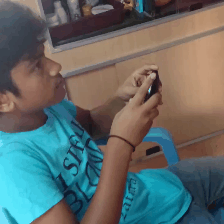

In [15]:
import time
i = 0 
for d in train_dataset:
    sample_video = d
    i+=1
    if i==4: break

display_gif(sample_video['video'])